# Task 1

Нужно написать две программы: Первая создает бинарный файл (min 2Гб), состоящий из случайных 32-разрядных беззнаковых целых чисел (big endian). Вторая считает сумму этих чисел (с применением длинной арифметики), находит минимальное и максимальное число.

Реализуйте две версии -

Простое последовательное чтение \
Многопоточная + memory-mapped files. Сравните время работы.

# File generation

Файлы с числами в формате big endian (4 байта информации). \
Чтобы размер файла был больше 2гб, необходимо 2 * 1024 * 1024 * 1024 / 4 == 536870912 чисел


In [5]:
import os
import random
from tqdm.notebook import tqdm
import struct

def generate_number():
    random_number = random.randint(0, 2**32-1)
    big_endian_bytes = struct.pack('>I', random_number)
    return big_endian_bytes

def generate_file(n=100, path='./', name='numbers', rm=False):
    file_path = os.path.join(path, name)

    if rm and os.path.exists(file_path):
        os.remove(file_path)

    with open(file_path, 'ab') as f:
        for _ in tqdm(range(n)):
            next_number = generate_number()
            f.write(next_number)

generate_file(n=536870912, rm=True)

100%|████████████████████████| 536870912/536870912 [04:43<00:00, 1896075.03it/s]


In [ ]:
%%time
def read_bigendian_file(file_name):
    with open(file_name, 'rb') as f:
        while byte := f.read(4):
            yield int.from_bytes(byte, byteorder='big')

def sequential_reading(file_name, total):

    overall_sum = 0
    overall_max = -1
    overall_min = 2**32

    for number in read_bigendian_file(file_name):

        overall_sum += number
        overall_max = max(overall_max, number)
        overall_min = min(overall_min, number)

    return overall_sum, overall_max, overall_min


n = 536870912
overall_sum, overall_max, overall_min = sequential_reading('./numbers', n)

In [12]:
print(overall_sum, overall_max, overall_min)

1152955616060133737 4294967295 5


In [9]:
%%time 

import mmap
from tqdm.notebook import tqdm
# multiprocess is fork of multiprocessing lib that works in iPython 
import multiprocess
import struct 
import os


def worker(worker_id, file_path, offset, chunk_size, result_queue):
    with open(file_path, 'rb') as f:
        mm = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)

        mm.seek(offset)

        data = mm.read(chunk_size)

        overall_sum = 0
        overall_max = -1
        overall_min = 2**32

        for i in range(0, len(data), 4):
            if i+4 <= len(data):
                number = struct.unpack('>I', data[i:i+4])[0]
                
                overall_sum += number
                overall_max = max(overall_max, number)
                overall_min = min(overall_min, number)

    result_queue.put((overall_sum, overall_max, overall_min))


def parallel_reading(file_path, num_workers, n):
    file_size = n * 4
    chunk_size = file_size // num_workers

    result_queue = multiprocess.Queue()

    processes = []
    for i in range(num_workers):
        offset = i * chunk_size

        p = multiprocess.Process(target=worker, args=(i, file_path, offset, chunk_size, result_queue))

        processes.append(p)
        p.start()

    # All gather
    overall_sum = 0
    overall_max = -1
    overall_min = 2**32

    for _ in range(num_workers):
        curr_sum, curr_max, curr_min = result_queue.get()
        
        overall_sum += curr_sum
        overall_max = max(overall_max, curr_max)
        overall_min = min(overall_min, curr_min)

    return overall_sum, overall_max, overall_min

global n 
n = 536870912
overall_sum, overall_max, overall_min = parallel_reading('./numbers', 10, n)

CPU times: user 5.88 ms, sys: 24.7 ms, total: 30.6 ms
Wall time: 20.4 s


In [10]:
print(overall_sum, overall_max, overall_min)

1152955609071586490 4294967295 5


Как можно заметить, результаты совпадают полностью, а при использовании 10 воркеров время рассчетов уменьшается в 8.7 раз

Рассмотрим зависимость времени исполнения от количества воркеров

In [ ]:
import time
data = {}
for num_workers in range(1, 25):
    t1 = time.time()
    parallel_reading('./numbers', num_workers, n)
    t2 = time.time()

    data[num_workers] = t2 - t1


Text(0, 0.5, 'Time (sec)')

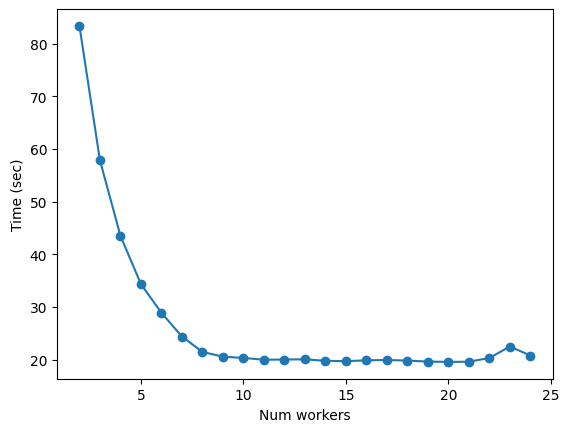

In [30]:
import matplotlib.pyplot as plt

x = range(2, 25)
plt.plot(x, [data[pt] for pt in x])
plt.scatter(x, [data[pt] for pt in x])

plt.xlabel('Num workers')
plt.ylabel('Time (sec)')

Из графика видно, что после дохода числа воркеров до 10 скорость выполнения замедляется, а иногда вообще увеличивается

Объяснение тому - количество реальных ядер процессора на машине, на которой выполнялись рассчеты.

Так как m1 Pro обладает 10 ядрами, ускорить выполнение процесса увеличением воркеров сверх 10 не получится с архитектурной точки зрения